In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian

In [2]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

green_fname = "TotalitySequenceGreen_22711(2)_l1.fit"
red_fname = "TotalitySequenceRed_7715_l1.fit"

In [42]:
green_frame = CCDData.read(os.path.join(green_path, green_fname),unit="adu")
red_frame = CCDData.read(os.path.join(red_path, red_fname),unit="adu")
green_image = green_frame.data/green_frame.header["EXPTIME"]
red_image = red_frame.data/red_frame.header["EXPTIME"]
green_wavelength = CCDData.read(os.path.join(green_path,green_fname),hdu=1,unit="angstrom").data
red_wavelength = CCDData.read(os.path.join(red_path,red_fname),hdu=1,unit="angstrom").data
green_xpixel_array = np.arange(green_frame.header["XWS"],green_frame.header["XWS"]+green_frame.header["NAXIS1"])
red_xpixel_array = np.arange(red_frame.header["XWS"],red_frame.header["XWS"]+red_frame.header["NAXIS1"])

In [7]:
norm_green = ImageNormalize(green_image,stretch=LogStretch())
norm_red = ImageNormalize(red_image,stretch=LogStretch())

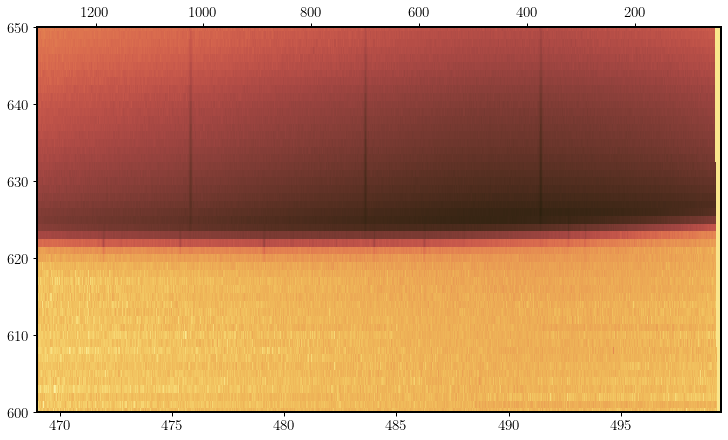

In [116]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
im_green = ax.pcolormesh(green_wavelength/68./10.,np.arange(green_frame.header["NAXIS2"]) + green_frame.header["YWS"],
                        green_image,cmap=cmcm.lajolla,norm=norm_green,shading='auto',rasterized=True)

ax_2 = ax.twiny()
ax_2.set_xlim((green_frame.header["NAXIS1"]-0.5,green_frame.header["XWS"]-0.5))
ax.set_ylim(600,650)
ax.tick_params(labelsize=15)
ax_2.tick_params(labelsize=15)

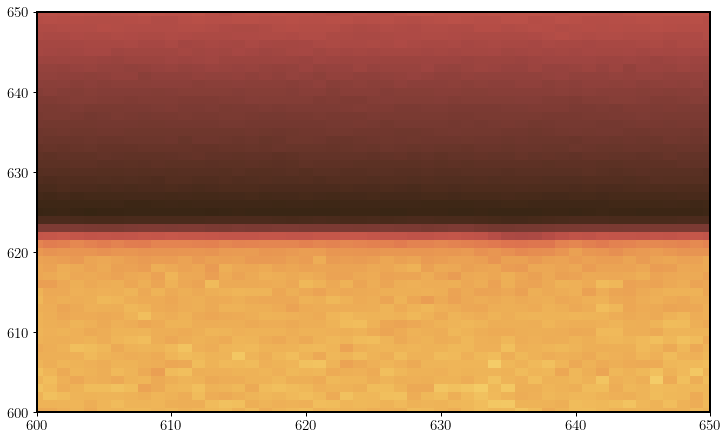

In [29]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
im_green = ax.pcolormesh(np.arange(green_frame.header["XWS"],green_frame.header["XWS"]+green_frame.header["NAXIS1"]),
                np.arange(green_frame.header["NAXIS2"]) + green_frame.header["YWS"],
                        green_image,cmap=cmcm.lajolla,norm=norm_green,shading='auto',rasterized=True)


ax.set_ylim(600,650)
ax.set_xlim(600,650)
# ax.axvline
ax.tick_params(labelsize=15)

In [123]:
Hbeta_wvl = 486.135
HeI_D3_wvl = 587.5621
Halpha_wvl = 656.279

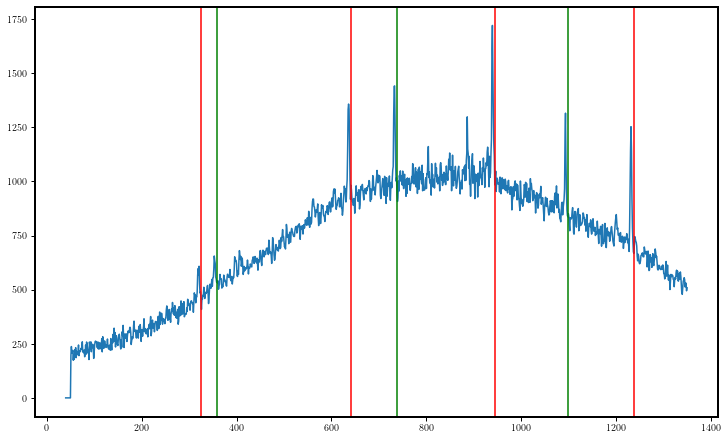

In [59]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.plot(green_xpixel_array,np.average(green_image[621 - green_frame.header["YWS"]:623 - green_frame.header["YWS"],:],axis=0))

for x_pos_ in (324.98,641.55,944.36,1236.286):
    ax.axvline(x_pos_,color="red")

for x_pos_ in (359.27,738.342,1098.72,):
    ax.axvline(x_pos_,color="green")

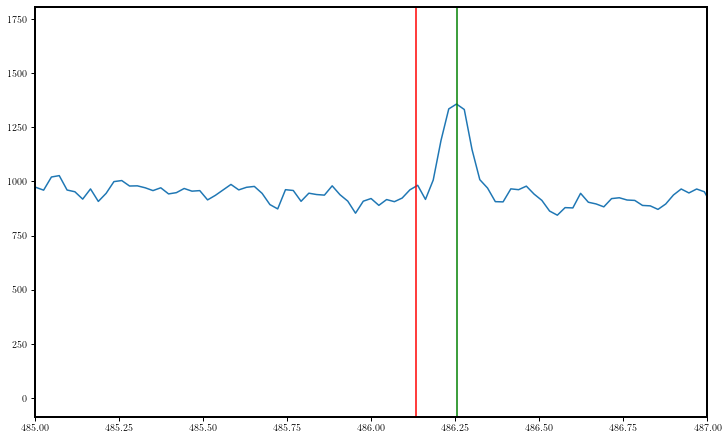

In [36]:

fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.plot(green_wavelength/68./10.,np.average(green_image[621 - green_frame.header["YWS"]:623 - green_frame.header["YWS"],:],axis=0))
ax.set_xlim(485,487)
# ax_2 = ax.twiny()
# ax_2.set_xlim((green_frame.header["NAXIS1"]-0.5,green_frame.header["XWS"]-0.5))
ax.axvline(Hbeta_wvl,color="red")
ax.axvline(486.255,color="green")

Pixel diff: -5.50 +/- 0.10 
 Wavelength diff: 0.118 +/- 0.002 nm 72.9 +/- 1.3 km/s


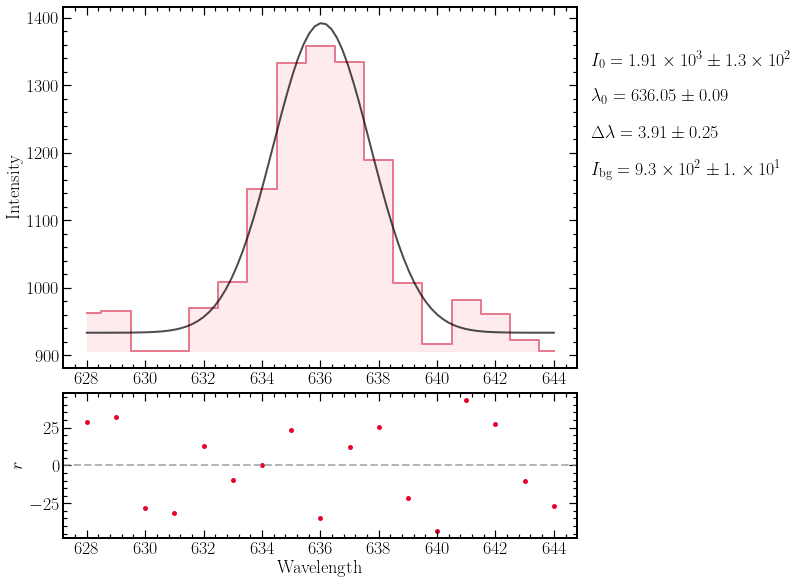

In [148]:
Hbeta_slice_68 = slice(628 - green_frame.header["XWS"],645 - green_frame.header["XWS"])
Hbeta_model_68 = SpectrumFitSingle(data=np.average(green_image[621 - green_frame.header["YWS"]:623 - green_frame.header["YWS"],
                    Hbeta_slice_68],axis=0), 
                    wvl=green_xpixel_array[Hbeta_slice_68],line_number=1,line_wvl_init=[635.],
                    int_max_init=[200],fwhm_init=[1],same_width=False)
Hbeta_model_68.run_lse(absolute_sigma=False)
ax = Hbeta_model_68.plot(plot_fit=True)
Hbeta_pixel_diff_68 = Hbeta_model_68.line_wvl_fit[0] - 641.55
Hbeta_pixel_diff_68_err = np.sqrt(Hbeta_model_68.line_wvl_err[0]**2 + 0.03**2)

Hbeta_wvl_diff_68 = np.interp(Hbeta_model_68.line_wvl_fit[0], green_xpixel_array, green_wavelength/68./10.) - Hbeta_wvl
Hbeta_wvl_diff_68_err = np.abs(np.interp(Hbeta_model_68.line_wvl_fit[0] + Hbeta_model_68.line_wvl_err[0], 
                    green_xpixel_array, green_wavelength/68./10.) - Hbeta_wvl - Hbeta_wvl_diff_68)

Hbeta_vlos_diff_68 = Hbeta_wvl_diff_68/Hbeta_wvl*3e5
Hbeta_vlos_diff_68_err = Hbeta_wvl_diff_68_err/Hbeta_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Hbeta_pixel_diff_68, Hbeta_pixel_diff_68_err,
                                                Hbeta_wvl_diff_68,Hbeta_wvl_diff_68_err, Hbeta_vlos_diff_68,Hbeta_vlos_diff_68_err))

Pixel diff: -5.11 +/- 0.24 
 Wavelength diff: 0.106 +/- 0.005 nm 65.4 +/- 3.3 km/s


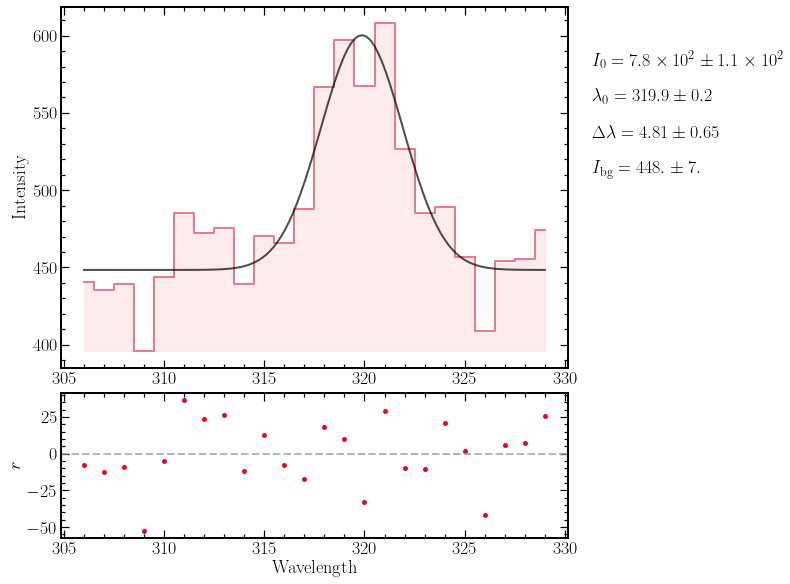

In [149]:
Hbeta_slice_69 = slice(306 - green_frame.header["XWS"],330 - green_frame.header["XWS"])
Hbeta_model_69 = SpectrumFitSingle(data=np.average(green_image[621 - green_frame.header["YWS"]:623 - green_frame.header["YWS"],
                    Hbeta_slice_69],axis=0), 
                    wvl=green_xpixel_array[Hbeta_slice_69],line_number=1,line_wvl_init=[320],
                    int_max_init=[200],fwhm_init=[1],same_width=False)
Hbeta_model_69.run_lse(absolute_sigma=False)
ax = Hbeta_model_69.plot(plot_fit=True)

Hbeta_pixel_diff_69 = Hbeta_model_69.line_wvl_fit[0] - 324.98
Hbeta_pixel_diff_69_err = np.sqrt(Hbeta_model_69.line_wvl_err[0]**2 + 0.02**2)

Hbeta_wvl_diff_69 = np.interp(Hbeta_model_69.line_wvl_fit[0], green_xpixel_array, green_wavelength/69./10.) - Hbeta_wvl
Hbeta_wvl_diff_69_err = np.abs(np.interp(Hbeta_model_69.line_wvl_fit[0] + Hbeta_model_69.line_wvl_err[0], 
                    green_xpixel_array, green_wavelength/69./10.) - Hbeta_wvl - Hbeta_wvl_diff_69)


Hbeta_vlos_diff_69 = Hbeta_wvl_diff_69/Hbeta_wvl*3e5
Hbeta_vlos_diff_69_err = Hbeta_wvl_diff_69_err/Hbeta_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Hbeta_pixel_diff_69, Hbeta_pixel_diff_69_err,
                                                Hbeta_wvl_diff_69,Hbeta_wvl_diff_69_err, Hbeta_vlos_diff_69,Hbeta_vlos_diff_69_err))

Pixel diff: -5.33 +/- 0.10 
 Wavelength diff: 0.132 +/- 0.002 nm 81.2 +/- 1.5 km/s


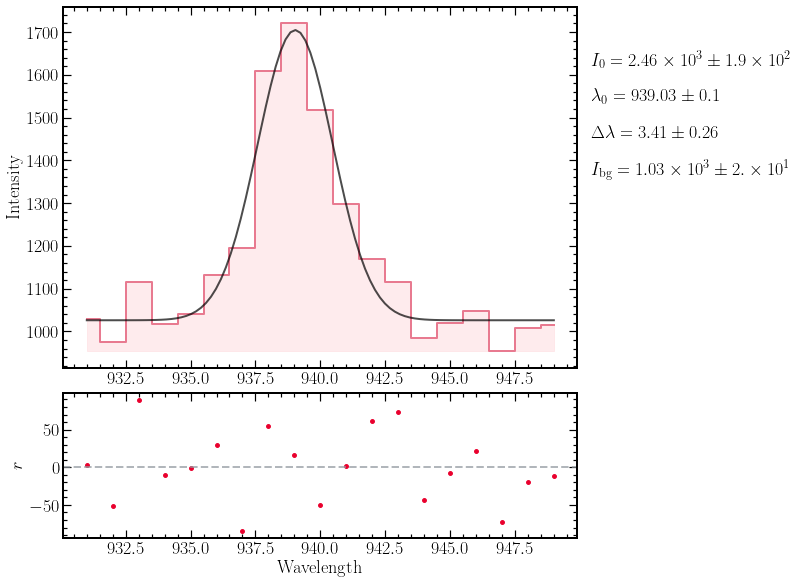

In [150]:
Hbeta_slice_67 = slice(931 - green_frame.header["XWS"],950 - green_frame.header["XWS"])
Hbeta_model_67 = SpectrumFitSingle(data=np.average(green_image[621 - green_frame.header["YWS"]:623 - green_frame.header["YWS"],
                    Hbeta_slice_67],axis=0), 
                    wvl=green_xpixel_array[Hbeta_slice_67],line_number=1,line_wvl_init=[938],
                    int_max_init=[200],fwhm_init=[1],same_width=False)
Hbeta_model_67.run_lse(absolute_sigma=False)
ax = Hbeta_model_67.plot(plot_fit=True)

Hbeta_pixel_diff_67 = Hbeta_model_67.line_wvl_fit[0] - 944.36
Hbeta_pixel_diff_67_err = np.sqrt(Hbeta_model_67.line_wvl_err[0]**2 + 0.02**2)

Hbeta_wvl_diff_67 = np.interp(Hbeta_model_67.line_wvl_fit[0], green_xpixel_array, green_wavelength/67./10.) - Hbeta_wvl
Hbeta_wvl_diff_67_err = np.abs(np.interp(Hbeta_model_67.line_wvl_fit[0] + Hbeta_model_67.line_wvl_err[0], 
                    green_xpixel_array, green_wavelength/67./10.) - Hbeta_wvl - Hbeta_wvl_diff_67)

Hbeta_vlos_diff_67 = Hbeta_wvl_diff_67/Hbeta_wvl*3e5
Hbeta_vlos_diff_67_err = Hbeta_wvl_diff_67_err/Hbeta_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Hbeta_pixel_diff_67, Hbeta_pixel_diff_67_err,
                                                Hbeta_wvl_diff_67,Hbeta_wvl_diff_67_err, Hbeta_vlos_diff_67,Hbeta_vlos_diff_67_err))

Pixel diff: -5.33 +/- 0.07 
 Wavelength diff: 0.131 +/- 0.002 nm 80.8 +/- 1.1 km/s


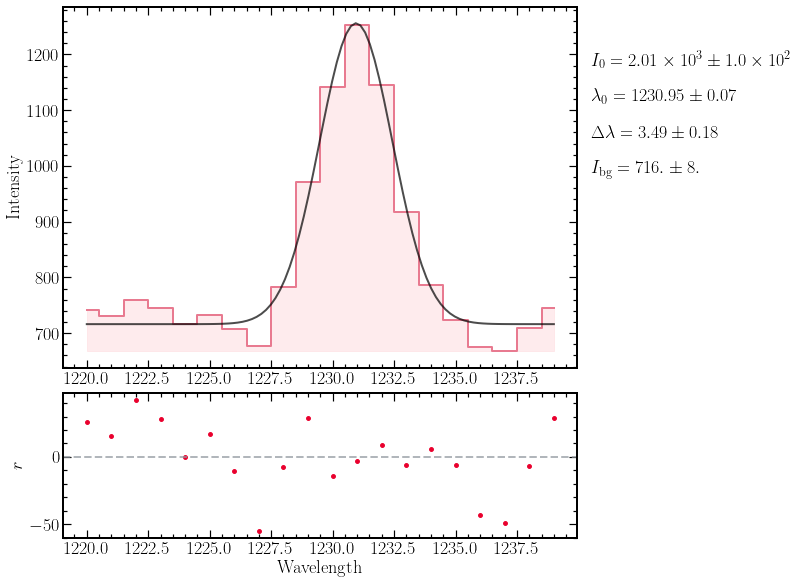

In [151]:
Hbeta_slice_66 = slice(1220 - green_frame.header["XWS"],1240 - green_frame.header["XWS"])
Hbeta_model_66 = SpectrumFitSingle(data=np.average(green_image[621 - green_frame.header["YWS"]:623 - green_frame.header["YWS"],
                    Hbeta_slice_66],axis=0), 
                    wvl=green_xpixel_array[Hbeta_slice_66],line_number=1,line_wvl_init=[1231],
                    int_max_init=[200],fwhm_init=[1],same_width=False)
Hbeta_model_66.run_lse(absolute_sigma=False)
ax = Hbeta_model_66.plot(plot_fit=True)

Hbeta_pixel_diff_66 = Hbeta_model_66.line_wvl_fit[0] - 1236.286
Hbeta_pixel_diff_66_err = np.sqrt(Hbeta_model_66.line_wvl_err[0]**2 + 0.009**2)

Hbeta_wvl_diff_66 = np.interp(Hbeta_model_66.line_wvl_fit[0], green_xpixel_array, green_wavelength/66./10.) - Hbeta_wvl
Hbeta_wvl_diff_66_err = np.abs(np.interp(Hbeta_model_66.line_wvl_fit[0] + Hbeta_model_66.line_wvl_err[0], 
                    green_xpixel_array, green_wavelength/66./10.) - Hbeta_wvl - Hbeta_wvl_diff_66)

Hbeta_vlos_diff_66 = Hbeta_wvl_diff_66/Hbeta_wvl*3e5
Hbeta_vlos_diff_66_err = Hbeta_wvl_diff_66_err/Hbeta_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Hbeta_pixel_diff_66, Hbeta_pixel_diff_66_err,
                                                Hbeta_wvl_diff_66,Hbeta_wvl_diff_66_err, Hbeta_vlos_diff_66,Hbeta_vlos_diff_66_err))

Pixel diff: -5.67 +/- 0.14 
 Wavelength diff: 0.155 +/- 0.004 nm 79.0 +/- 1.9 km/s


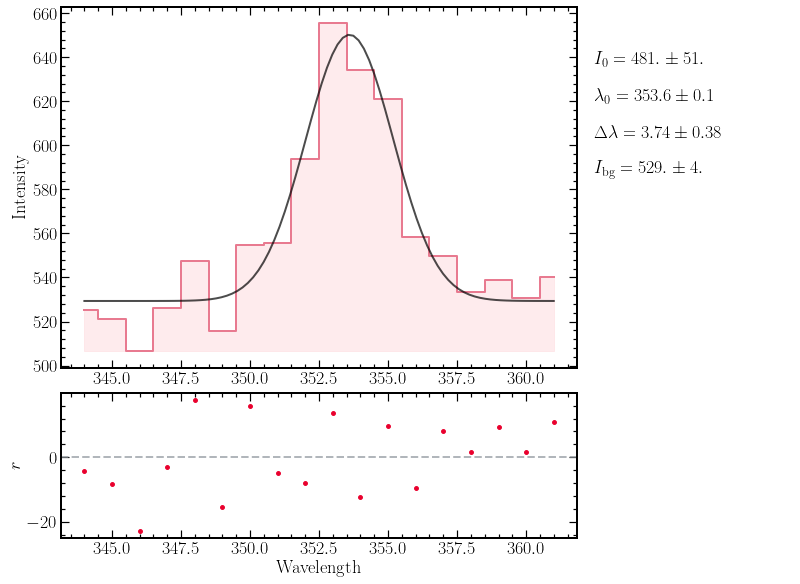

In [155]:
HeI_D3_slice_57_green = slice(344 - green_frame.header["XWS"],362 - green_frame.header["XWS"])
HeI_D3_model_57_green = SpectrumFitSingle(data=np.average(green_image[621 - green_frame.header["YWS"]:623 - green_frame.header["YWS"],
                    HeI_D3_slice_57_green],axis=0), 
                    wvl=green_xpixel_array[HeI_D3_slice_57_green],line_number=1,line_wvl_init=[353.],
                    int_max_init=[100],fwhm_init=[1],same_width=False)
HeI_D3_model_57_green.run_lse(absolute_sigma=False)
ax = HeI_D3_model_57_green.plot(plot_fit=True)

HeI_D3_pixel_diff_57_green = HeI_D3_model_57_green.line_wvl_fit[0] - 359.27
HeI_D3_pixel_diff_57_green_err = np.sqrt(HeI_D3_model_57_green.line_wvl_err[0]**2 + 0.01**2)

HeI_D3_wvl_diff_57_green = np.interp(HeI_D3_model_57_green.line_wvl_fit[0], green_xpixel_array, green_wavelength/57./10.) - HeI_D3_wvl
HeI_D3_wvl_diff_57_green_err = np.abs(np.interp(HeI_D3_model_57_green.line_wvl_fit[0] + HeI_D3_model_57_green.line_wvl_err[0], 
                    green_xpixel_array, green_wavelength/57./10.) - HeI_D3_wvl - HeI_D3_wvl_diff_57_green)

HeI_D3_vlos_diff_57_green = HeI_D3_wvl_diff_57_green/HeI_D3_wvl*3e5
HeI_D3_vlos_diff_57_green_err = HeI_D3_wvl_diff_57_green_err/HeI_D3_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(HeI_D3_pixel_diff_57_green, HeI_D3_pixel_diff_57_green_err,
                                                HeI_D3_wvl_diff_57_green,HeI_D3_wvl_diff_57_green_err, HeI_D3_vlos_diff_57_green,HeI_D3_vlos_diff_57_green_err))

Pixel diff: -5.88 +/- 0.10 
 Wavelength diff: 0.169 +/- 0.003 nm 86.1 +/- 1.4 km/s


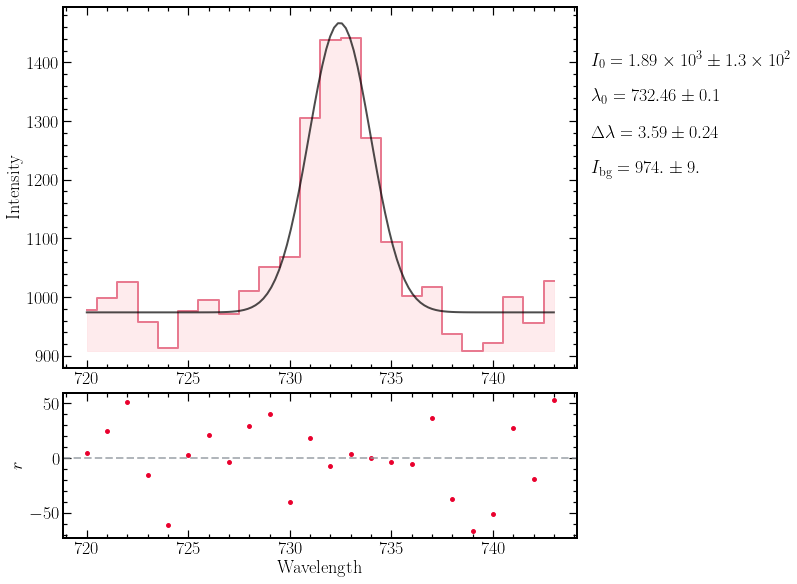

In [156]:
HeI_D3_slice_56_green = slice(720 - green_frame.header["XWS"],744 - green_frame.header["XWS"])
HeI_D3_model_56_green = SpectrumFitSingle(data=np.average(green_image[621 - green_frame.header["YWS"]:623 - green_frame.header["YWS"],
                    HeI_D3_slice_56_green],axis=0),
                    wvl=green_xpixel_array[HeI_D3_slice_56_green],line_number=1,line_wvl_init=[732.],
                    int_max_init=[400],fwhm_init=[1],same_width=False)
HeI_D3_model_56_green.run_lse(absolute_sigma=False)
ax = HeI_D3_model_56_green.plot(plot_fit=True)

HeI_D3_pixel_diff_56_green = HeI_D3_model_56_green.line_wvl_fit[0] - 738.342
HeI_D3_pixel_diff_56_green_err = np.sqrt(HeI_D3_model_56_green.line_wvl_err[0]**2 + 0.005**2)

HeI_D3_wvl_diff_56_green = np.interp(HeI_D3_model_56_green.line_wvl_fit[0], green_xpixel_array, green_wavelength/56./10.) - HeI_D3_wvl
HeI_D3_wvl_diff_56_green_err = np.abs(np.interp(HeI_D3_model_56_green.line_wvl_fit[0] + HeI_D3_model_56_green.line_wvl_err[0], 
                    green_xpixel_array, green_wavelength/56./10.) - HeI_D3_wvl - HeI_D3_wvl_diff_56_green)

HeI_D3_vlos_diff_56_green = HeI_D3_wvl_diff_56_green/HeI_D3_wvl*3e5
HeI_D3_vlos_diff_56_green_err = HeI_D3_wvl_diff_56_green_err/HeI_D3_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(HeI_D3_pixel_diff_56_green, HeI_D3_pixel_diff_56_green_err,
                                                HeI_D3_wvl_diff_56_green,HeI_D3_wvl_diff_56_green_err, HeI_D3_vlos_diff_56_green,HeI_D3_vlos_diff_56_green_err))

Pixel diff: -5.90 +/- 0.09 
 Wavelength diff: 0.183 +/- 0.003 nm 93.3 +/- 1.3 km/s


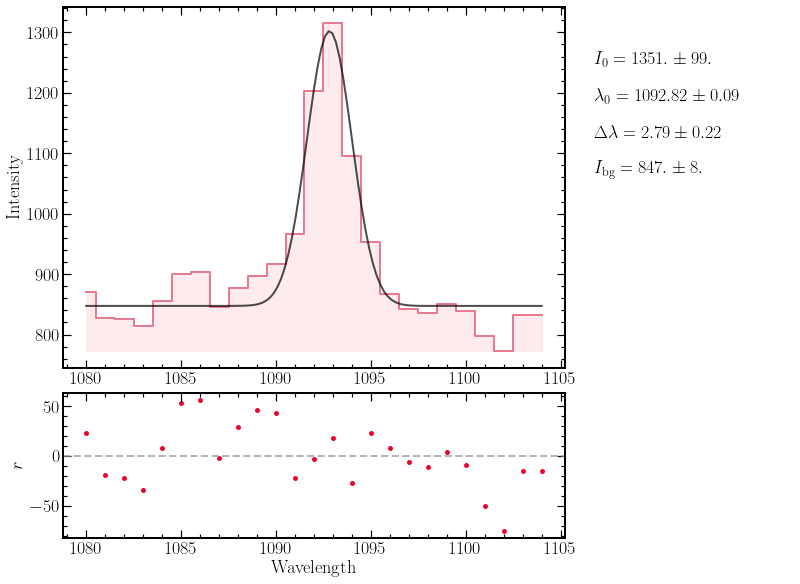

In [157]:
HeI_D3_slice_55_green = slice(1080 - green_frame.header["XWS"],1105 - green_frame.header["XWS"])
HeI_D3_model_55_green = SpectrumFitSingle(data=np.average(green_image[621 - green_frame.header["YWS"]:623 - green_frame.header["YWS"],
                    HeI_D3_slice_55_green],axis=0),
                    wvl=green_xpixel_array[HeI_D3_slice_55_green],line_number=1,line_wvl_init=[1092.],
                    int_max_init=[400],fwhm_init=[1],same_width=False)
HeI_D3_model_55_green.run_lse(absolute_sigma=False)
ax = HeI_D3_model_55_green.plot(plot_fit=True)

HeI_D3_pixel_diff_55_green = HeI_D3_model_55_green.line_wvl_fit[0] - 1098.72
HeI_D3_pixel_diff_55_green_err = np.sqrt(HeI_D3_model_55_green.line_wvl_err[0]**2 + 0.03**2)

HeI_D3_wvl_diff_55_green = np.interp(HeI_D3_model_55_green.line_wvl_fit[0], green_xpixel_array, green_wavelength/55./10.) - HeI_D3_wvl
HeI_D3_wvl_diff_55_green_err = np.abs(np.interp(HeI_D3_model_55_green.line_wvl_fit[0] + HeI_D3_model_55_green.line_wvl_err[0], 
                    green_xpixel_array, green_wavelength/55./10.) - HeI_D3_wvl - HeI_D3_wvl_diff_55_green)

HeI_D3_vlos_diff_55_green = HeI_D3_wvl_diff_55_green/HeI_D3_wvl*3e5
HeI_D3_vlos_diff_55_green_err = HeI_D3_wvl_diff_55_green_err/HeI_D3_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(HeI_D3_pixel_diff_55_green, HeI_D3_pixel_diff_55_green_err,
                                                HeI_D3_wvl_diff_55_green,HeI_D3_wvl_diff_55_green_err, HeI_D3_vlos_diff_55_green,HeI_D3_vlos_diff_55_green_err))

In [158]:
Hbeta_centorid_pixels = np.array([Hbeta_model_69.line_wvl_fit[0],Hbeta_model_68.line_wvl_fit[0],
                                Hbeta_model_67.line_wvl_fit[0],Hbeta_model_66.line_wvl_fit[0]])
HeI_D3_centorid_pixels_green = np.array([HeI_D3_model_57_green.line_wvl_fit[0],HeI_D3_model_56_green.line_wvl_fit[0],
                                HeI_D3_model_55_green.line_wvl_fit[0]])    

Hbeta_centorid_pixels_err = np.array([Hbeta_model_69.line_wvl_err[0],Hbeta_model_68.line_wvl_err[0],
                                Hbeta_model_67.line_wvl_err[0],Hbeta_model_66.line_wvl_err[0]])
HeI_D3_centorid_pixels_green_err = np.array([HeI_D3_model_57_green.line_wvl_err[0],HeI_D3_model_56_green.line_wvl_err[0],
                                HeI_D3_model_55_green.line_wvl_err[0]])    

Hbeta_pixel_diffs = np.array([Hbeta_pixel_diff_69,Hbeta_pixel_diff_68,Hbeta_pixel_diff_67,Hbeta_pixel_diff_66])            
HeI_D3_pixel_diffs_green = np.array([HeI_D3_pixel_diff_57_green,HeI_D3_pixel_diff_56_green,HeI_D3_pixel_diff_55_green])

Hbeta_pixel_diffs_err = np.array([Hbeta_pixel_diff_69_err,Hbeta_pixel_diff_68_err,Hbeta_pixel_diff_67_err,Hbeta_pixel_diff_66_err])            
HeI_D3_pixel_diffs_green_err = np.array([HeI_D3_pixel_diff_57_green_err,HeI_D3_pixel_diff_56_green_err,HeI_D3_pixel_diff_55_green_err])

Hbeta_wvl_diffs = np.array([Hbeta_wvl_diff_69,Hbeta_wvl_diff_68,Hbeta_wvl_diff_67,Hbeta_wvl_diff_66])    
HeI_D3_wvl_diffs_green = np.array([HeI_D3_wvl_diff_57_green,HeI_D3_wvl_diff_56_green,HeI_D3_wvl_diff_55_green])

Hbeta_wvl_diffs_err = np.array([Hbeta_wvl_diff_69_err,Hbeta_wvl_diff_68_err,Hbeta_wvl_diff_67_err,Hbeta_wvl_diff_66_err])    
HeI_D3_wvl_diffs_green_err = np.array([HeI_D3_wvl_diff_57_green_err,HeI_D3_wvl_diff_56_green_err,HeI_D3_wvl_diff_55_green_err])

Hbeta_vlos_diffs = np.array([Hbeta_vlos_diff_69,Hbeta_vlos_diff_68,Hbeta_vlos_diff_67,Hbeta_vlos_diff_66])    
HeI_D3_vlos_diffs_green = np.array([HeI_D3_vlos_diff_57_green,HeI_D3_vlos_diff_56_green,HeI_D3_vlos_diff_55_green])

Hbeta_vlos_diffs_err = np.array([Hbeta_vlos_diff_69_err,Hbeta_vlos_diff_68_err,Hbeta_vlos_diff_67_err,Hbeta_vlos_diff_66_err])    
HeI_D3_vlos_diffs_green_err = np.array([HeI_D3_vlos_diff_57_green_err,HeI_D3_vlos_diff_56_green_err,HeI_D3_vlos_diff_55_green_err])

Averaged pixel shift: -5.557


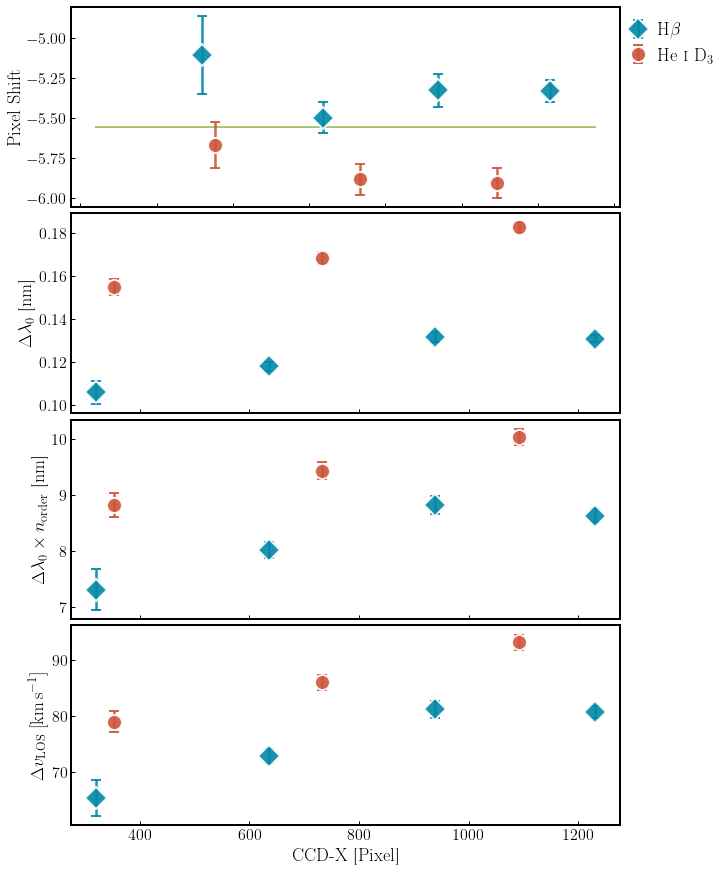

In [191]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(10,12),constrained_layout=True)

ax1.errorbar(Hbeta_centorid_pixels, Hbeta_pixel_diffs,Hbeta_pixel_diffs_err,color="#0089A7",ls="none",marker="D",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"H$\beta$")

ax1.errorbar(HeI_D3_centorid_pixels_green, HeI_D3_pixel_diffs_green,HeI_D3_pixel_diffs_green_err,color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"He \textsc{i} $\mathrm{D_3}$")

green_abs_wvl_corr_params = np.polyfit(np.concatenate((Hbeta_centorid_pixels, HeI_D3_centorid_pixels_green)),
                                    np.concatenate((Hbeta_pixel_diffs, HeI_D3_pixel_diffs_green)),
                                    w = 1./np.concatenate((Hbeta_pixel_diffs_err, HeI_D3_pixel_diffs_green_err)),
                                    deg = 0)

green_abs_wvl_corr_poly = np.poly1d(green_abs_wvl_corr_params)

ax1.plot(np.linspace(green_frame.header["XWS"],green_frame.header["XWS"]+green_frame.header["NAXIS1"],green_frame.header["NAXIS1"]), 
        green_abs_wvl_corr_poly(np.linspace(green_frame.header["XWS"],green_frame.header["XWS"]+green_frame.header["NAXIS1"],green_frame.header["NAXIS1"])),
        color="#90B44B",zorder=0)

ax1.legend(bbox_to_anchor = (1.2,1),loc="upper right",fontsize=18,frameon=False,handletextpad=0.1)

ax2.errorbar(Hbeta_centorid_pixels, Hbeta_wvl_diffs,Hbeta_wvl_diffs_err,color="#0089A7",ls="none",marker="D",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"H$\beta$")

ax2.errorbar(HeI_D3_centorid_pixels_green, HeI_D3_wvl_diffs_green,HeI_D3_wvl_diffs_green_err,color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"He \textsc{i} $\mathrm{D_3}$")

ax3.errorbar(Hbeta_centorid_pixels, Hbeta_wvl_diffs*np.array([69,68,67,66]),
            Hbeta_wvl_diffs_err*np.array([69,68,67,66]),color="#0089A7",ls="none",marker="D",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"H$\beta$")

ax3.errorbar(HeI_D3_centorid_pixels_green, HeI_D3_wvl_diffs_green*np.array([57,56,55]),
            HeI_D3_wvl_diffs_green_err*np.array([57,56,55]),color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"He \textsc{i} $\mathrm{D_3}$")

ax4.errorbar(Hbeta_centorid_pixels, Hbeta_vlos_diffs,Hbeta_vlos_diffs_err,color="#0089A7",ls="none",marker="D",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"H$\beta$")

ax4.errorbar(HeI_D3_centorid_pixels_green, HeI_D3_vlos_diffs_green,HeI_D3_vlos_diffs_green_err,color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"He \textsc{i} $\mathrm{D_3}$")


ax1.set_ylabel(r"Pixel Shift",fontsize=18)
ax2.set_ylabel(r"$\Delta\lambda_{0}$ [nm]",fontsize=18)
ax3.set_ylabel(r"$\Delta\lambda_{0}\times n_{\rm order}$ [nm]",fontsize=18)
ax4.set_ylabel(r"$\Delta v_{\rm LOS}\ [\mathrm{km\,s^{-1}}]$",fontsize=18)
ax4.set_xlabel(r"CCD-X [Pixel]",fontsize=18)
for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4):
    ax_.tick_params(labelsize=16,direction="in")

print("Averaged pixel shift: {:.3f}".format(green_abs_wvl_corr_poly(500)))
    

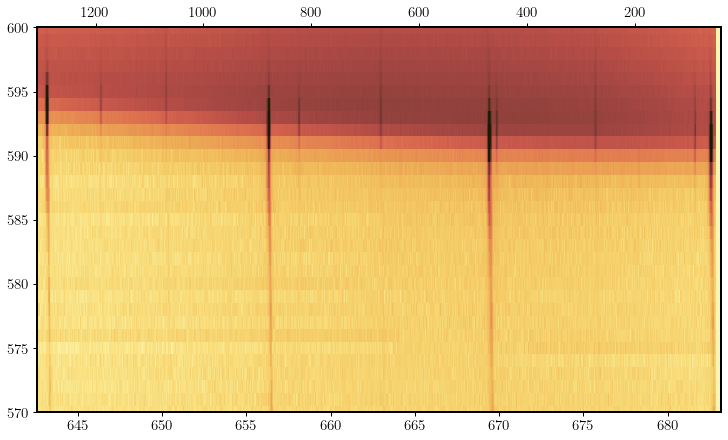

In [118]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
im_red = ax.pcolormesh(red_wavelength/50./10.,np.arange(red_frame.header["NAXIS2"]) + red_frame.header["YWS"],
                        red_image,cmap=cmcm.lajolla,norm=norm_red,shading='auto',rasterized=True)

ax_2 = ax.twiny()
ax_2.set_xlim((red_frame.header["NAXIS1"]-0.5,red_frame.header["XWS"]-0.5))
ax.set_ylim(570,600)
ax.tick_params(labelsize=15)
ax_2.tick_params(labelsize=15)

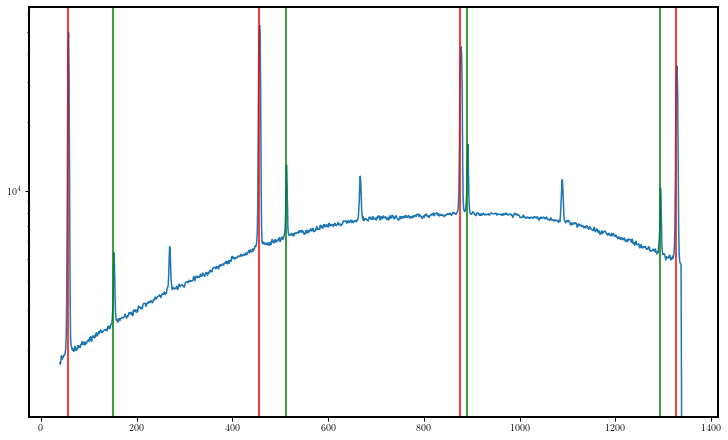

In [122]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.plot(red_xpixel_array,np.average(red_image[592 - red_frame.header["YWS"]:596 - red_frame.header["YWS"],:],axis=0))
ax.set_yscale("log")

for x_pos_ in (56.632, 455.637, 876.324, 1326.913):
    ax.axvline(x_pos_,color="red")

for x_pos_ in (151.42, 511.91, 890.45, 1293.00 ):
    ax.axvline(x_pos_,color="green")

Pixel diff: 1.10 +/- 0.01 
 Wavelength diff: 0.020 +/- 0.000 nm 8.9 +/- 0.2 km/s


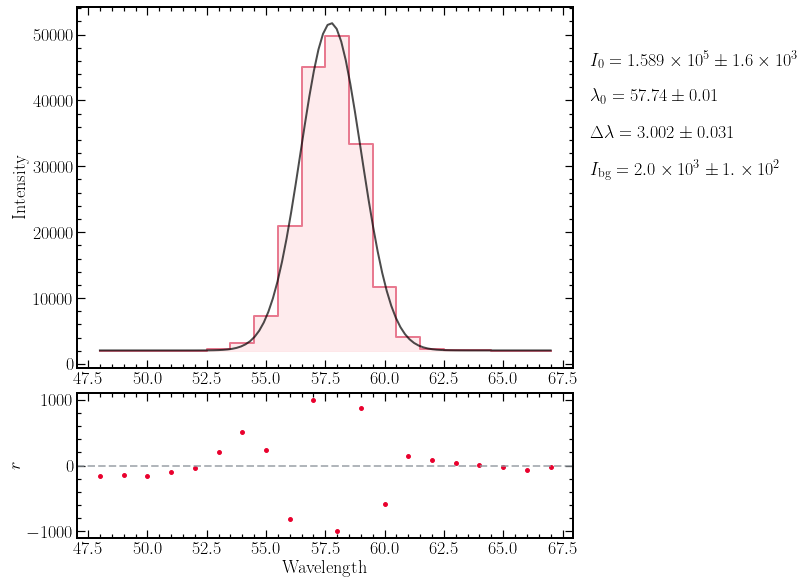

In [169]:
Halpha_slice_49 = slice(48 - red_frame.header["XWS"],68 - red_frame.header["XWS"])
Halpha_model_49 = SpectrumFitSingle(data=np.average(red_image[592 - red_frame.header["YWS"]:596 - red_frame.header["YWS"],
                    Halpha_slice_49],axis=0), 
                    wvl=red_xpixel_array[Halpha_slice_49],line_number=1,line_wvl_init=[57.5],
                    int_max_init=50000,fwhm_init=[1],same_width=False)
Halpha_model_49.run_lse(absolute_sigma=False)
ax = Halpha_model_49.plot(plot_fit=True)
Halpha_pixel_diff_49 = Halpha_model_49.line_wvl_fit[0] - 56.632
Halpha_pixel_diff_49_err = np.sqrt(Halpha_model_49.line_wvl_err[0]**2 + 0.004**2)


Halpha_wvl_diff_49 = np.interp(Halpha_model_49.line_wvl_fit[0], red_xpixel_array, red_wavelength/49./10.) - Halpha_wvl
Halpha_wvl_diff_49_err = np.abs(np.interp(Halpha_model_49.line_wvl_fit[0] + Halpha_model_49.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/49./10.) - Halpha_wvl - Halpha_wvl_diff_49)

Halpha_vlos_diff_49 = Halpha_wvl_diff_49/Halpha_wvl*3e5
Halpha_vlos_diff_49_err = Halpha_wvl_diff_49_err/Halpha_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Halpha_pixel_diff_49, Halpha_pixel_diff_49_err,
                                                Halpha_wvl_diff_49,Halpha_wvl_diff_49_err, Halpha_vlos_diff_49,Halpha_vlos_diff_49_err))

Pixel diff: 1.11 +/- 0.05 
 Wavelength diff: 0.047 +/- 0.002 nm 21.4 +/- 0.7 km/s


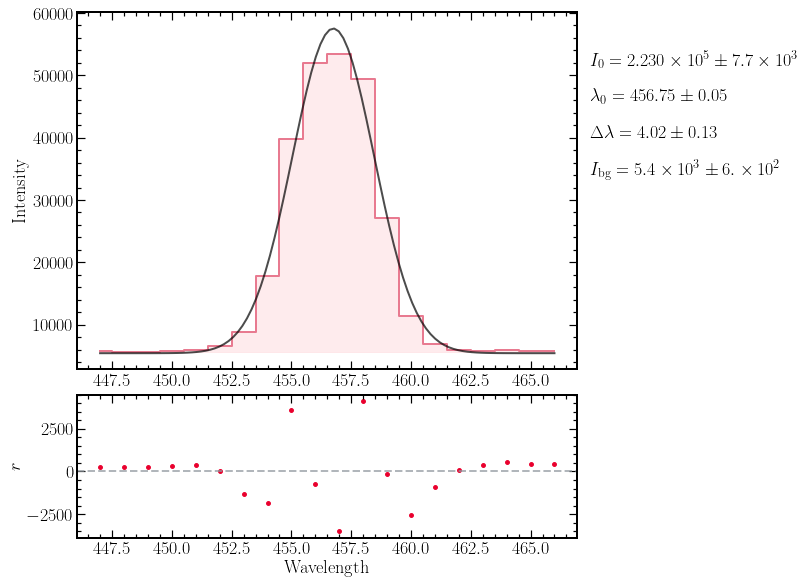

In [171]:
Halpha_slice_50 = slice(447 - red_frame.header["XWS"],467 - red_frame.header["XWS"])
Halpha_model_50 = SpectrumFitSingle(data=np.average(red_image[592 - red_frame.header["YWS"]:596 - red_frame.header["YWS"],
                    Halpha_slice_50],axis=0), 
                    wvl=red_xpixel_array[Halpha_slice_50],line_number=1,line_wvl_init=[456.6],
                    int_max_init=40000,fwhm_init=[1],same_width=False)
Halpha_model_50.run_lse(absolute_sigma=False)
ax = Halpha_model_50.plot(plot_fit=True)
Halpha_pixel_diff_50 = Halpha_model_50.line_wvl_fit[0] - 455.637
Halpha_pixel_diff_50_err = np.sqrt(Halpha_model_50.line_wvl_err[0]**2 + 0.004**2)

Halpha_wvl_diff_50 = np.interp(Halpha_model_50.line_wvl_fit[0], red_xpixel_array, red_wavelength/50./10.) - Halpha_wvl
Halpha_wvl_diff_50_err = np.abs(np.interp(Halpha_model_50.line_wvl_fit[0] + Halpha_model_50.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/50./10.) - Halpha_wvl - Halpha_wvl_diff_50)

Halpha_vlos_diff_50 = Halpha_wvl_diff_50/Halpha_wvl*3e5
Halpha_vlos_diff_50_err = Halpha_wvl_diff_50_err/Halpha_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Halpha_pixel_diff_50, Halpha_pixel_diff_50_err,
                                                Halpha_wvl_diff_50,Halpha_wvl_diff_50_err, Halpha_vlos_diff_50,Halpha_vlos_diff_50_err))

Pixel diff: 1.22 +/- 0.06 
 Wavelength diff: 0.020 +/- 0.002 nm 8.9 +/- 0.8 km/s


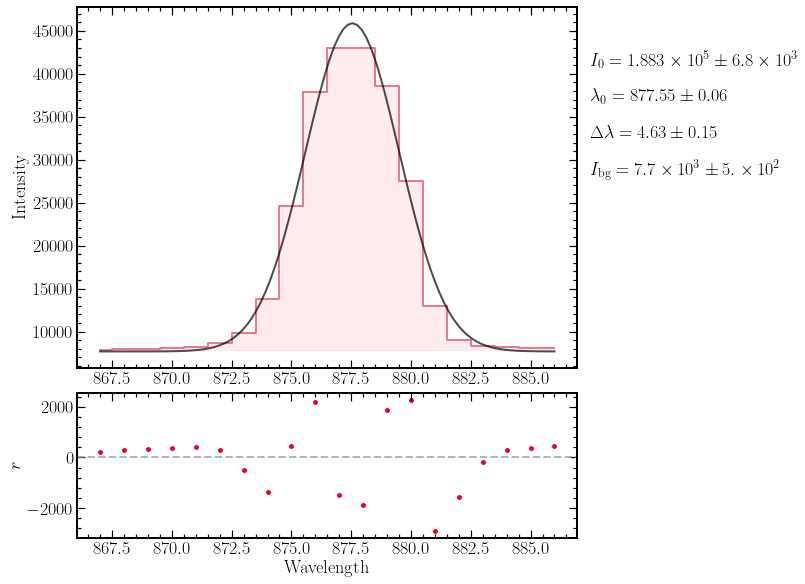

In [172]:
Halpha_slice_51 = slice(867 - red_frame.header["XWS"],887 - red_frame.header["XWS"])
Halpha_model_51 = SpectrumFitSingle(data=np.average(red_image[592 - red_frame.header["YWS"]:596 - red_frame.header["YWS"],
                    Halpha_slice_51],axis=0), 
                    wvl=red_xpixel_array[Halpha_slice_51],line_number=1,line_wvl_init=[877.3],
                    int_max_init=40000,fwhm_init=[1],same_width=False)
Halpha_model_51.run_lse(absolute_sigma=False)
ax = Halpha_model_51.plot(plot_fit=True)
Halpha_pixel_diff_51 = Halpha_model_51.line_wvl_fit[0] - 876.324
Halpha_pixel_diff_51_err = np.sqrt(Halpha_model_51.line_wvl_err[0]**2 + 0.006**2)

Halpha_wvl_diff_51 = np.interp(Halpha_model_51.line_wvl_fit[0], red_xpixel_array, red_wavelength/51./10.) - Halpha_wvl
Halpha_wvl_diff_51_err = np.abs(np.interp(Halpha_model_51.line_wvl_fit[0] + Halpha_model_51.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/51./10.) - Halpha_wvl - Halpha_wvl_diff_51)

Halpha_vlos_diff_51 = Halpha_wvl_diff_51/Halpha_wvl*3e5
Halpha_vlos_diff_51_err = Halpha_wvl_diff_51_err/Halpha_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Halpha_pixel_diff_51, Halpha_pixel_diff_51_err,
                                                Halpha_wvl_diff_51,Halpha_wvl_diff_51_err, Halpha_vlos_diff_51,Halpha_vlos_diff_51_err))

Pixel diff: 1.27 +/- 0.04 
 Wavelength diff: 0.041 +/- 0.001 nm 18.7 +/- 0.5 km/s


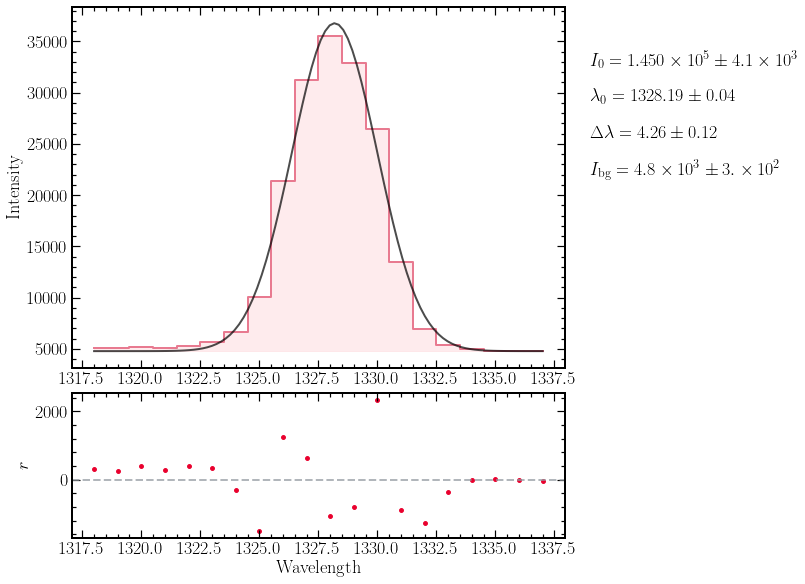

In [173]:
Halpha_slice_52 = slice(1318 - red_frame.header["XWS"],1338 - red_frame.header["XWS"])
Halpha_model_52 = SpectrumFitSingle(data=np.average(red_image[592 - red_frame.header["YWS"]:596 - red_frame.header["YWS"],
                    Halpha_slice_52],axis=0), 
                    wvl=red_xpixel_array[Halpha_slice_52],line_number=1,line_wvl_init=[1327.9],
                    int_max_init=40000,fwhm_init=[1],same_width=False)
Halpha_model_52.run_lse(absolute_sigma=False)
ax = Halpha_model_52.plot(plot_fit=True)
Halpha_pixel_diff_52 = Halpha_model_52.line_wvl_fit[0] - 1326.913
Halpha_pixel_diff_52_err = np.sqrt(Halpha_model_52.line_wvl_err[0]**2 + 0.005**2)

Halpha_wvl_diff_52 = np.interp(Halpha_model_52.line_wvl_fit[0], red_xpixel_array, red_wavelength/52./10.) - Halpha_wvl
Halpha_wvl_diff_52_err = np.abs(np.interp(Halpha_model_52.line_wvl_fit[0] + Halpha_model_52.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/52./10.) - Halpha_wvl - Halpha_wvl_diff_52)

Halpha_vlos_diff_52 = Halpha_wvl_diff_52/Halpha_wvl*3e5
Halpha_vlos_diff_52_err = Halpha_wvl_diff_52_err/Halpha_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(Halpha_pixel_diff_52, Halpha_pixel_diff_52_err,
                                                Halpha_wvl_diff_52,Halpha_wvl_diff_52_err, Halpha_vlos_diff_52,Halpha_vlos_diff_52_err))

Pixel diff: 1.49 +/- 0.04 
 Wavelength diff: 0.051 +/- 0.001 nm 26.3 +/- 0.5 km/s


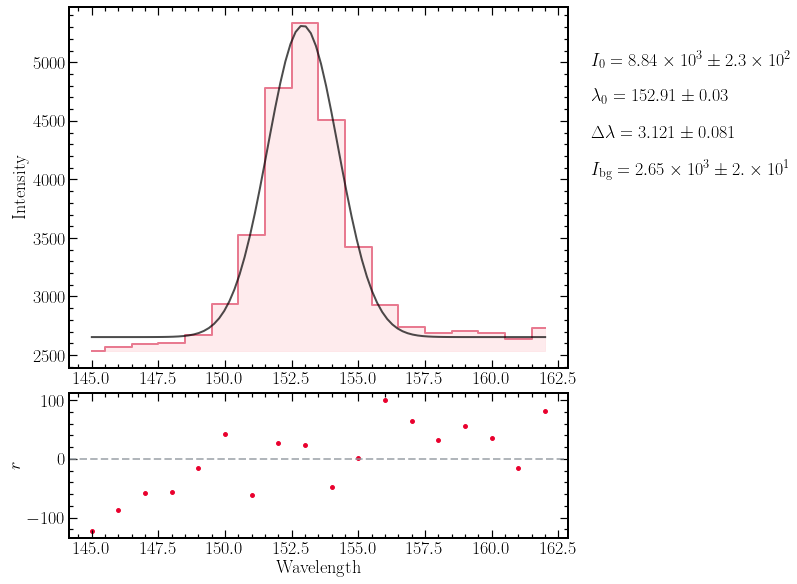

In [178]:
HeI_D3_slice_55_red = slice(145 - red_frame.header["XWS"],163 - red_frame.header["XWS"])
HeI_D3_model_55_red = SpectrumFitSingle(data=np.average(red_image[592 - red_frame.header["YWS"]:596 - red_frame.header["YWS"],
                    HeI_D3_slice_55_red],axis=0), 
                    wvl=red_xpixel_array[HeI_D3_slice_55_red],line_number=1,line_wvl_init=[152.4],
                    int_max_init=50000,fwhm_init=[1],same_width=False)
HeI_D3_model_55_red.run_lse(absolute_sigma=False)
ax = HeI_D3_model_55_red.plot(plot_fit=True)
HeI_D3_pixel_diff_55_red = HeI_D3_model_55_red.line_wvl_fit[0] - 151.42
HeI_D3_pixel_diff_55_red_err = np.sqrt(HeI_D3_model_55_red.line_wvl_err[0]**2 + 0.02**2)

HeI_D3_wvl_diff_55_red = np.interp(HeI_D3_model_55_red.line_wvl_fit[0], red_xpixel_array, red_wavelength/55./10.) - HeI_D3_wvl
HeI_D3_wvl_diff_55_red_err = np.abs(np.interp(HeI_D3_model_55_red.line_wvl_fit[0] + HeI_D3_model_55_red.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/55./10.) - HeI_D3_wvl - HeI_D3_wvl_diff_55_red)

HeI_D3_vlos_diff_55_red = HeI_D3_wvl_diff_55_red/HeI_D3_wvl*3e5
HeI_D3_vlos_diff_55_red_err = HeI_D3_wvl_diff_55_red_err/HeI_D3_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(HeI_D3_pixel_diff_55_red, HeI_D3_pixel_diff_55_red_err,
                                                HeI_D3_wvl_diff_55_red,HeI_D3_wvl_diff_55_red_err, HeI_D3_vlos_diff_55_red,HeI_D3_vlos_diff_55_red_err))

Pixel diff: 1.29 +/- 0.04 
 Wavelength diff: 0.053 +/- 0.001 nm 27.1 +/- 0.4 km/s


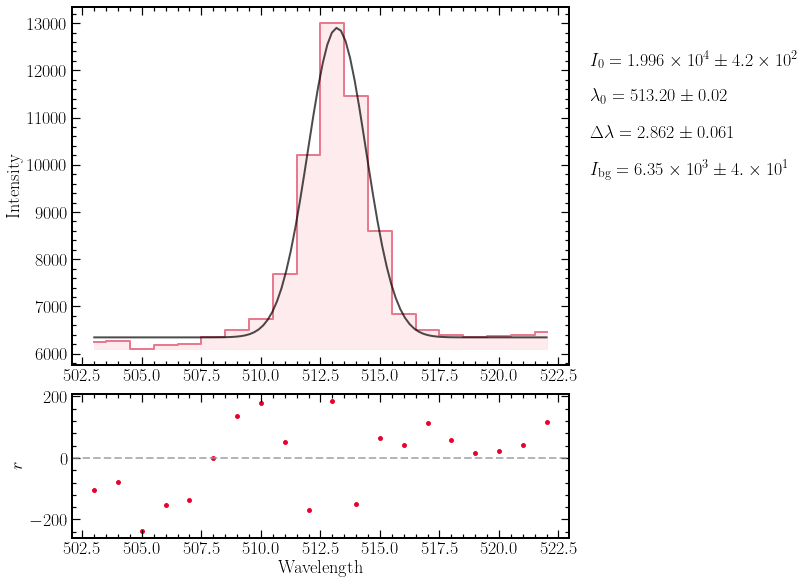

In [175]:
HeI_D3_slice_56_red = slice(503 - red_frame.header["XWS"],523 - red_frame.header["XWS"])
HeI_D3_model_56_red = SpectrumFitSingle(data=np.average(red_image[592 - red_frame.header["YWS"]:596 - red_frame.header["YWS"],
                    HeI_D3_slice_56_red],axis=0), 
                    wvl=red_xpixel_array[HeI_D3_slice_56_red],line_number=1,line_wvl_init=[512.91],
                    int_max_init=50000,fwhm_init=[1],same_width=False)
HeI_D3_model_56_red.run_lse(absolute_sigma=False)
ax = HeI_D3_model_56_red.plot(plot_fit=True)
HeI_D3_pixel_diff_56_red = HeI_D3_model_56_red.line_wvl_fit[0] - 511.91
HeI_D3_pixel_diff_56_red_err = np.sqrt(HeI_D3_model_56_red.line_wvl_err[0]**2 + 0.03**2)

HeI_D3_wvl_diff_56_red = np.interp(HeI_D3_model_56_red.line_wvl_fit[0], red_xpixel_array, red_wavelength/56./10.) - HeI_D3_wvl
HeI_D3_wvl_diff_56_red_err = np.abs(np.interp(HeI_D3_model_56_red.line_wvl_fit[0] + HeI_D3_model_56_red.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/56./10.) - HeI_D3_wvl - HeI_D3_wvl_diff_56_red)

HeI_D3_vlos_diff_56_red = HeI_D3_wvl_diff_56_red/HeI_D3_wvl*3e5
HeI_D3_vlos_diff_56_red_err = HeI_D3_wvl_diff_56_red_err/HeI_D3_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(HeI_D3_pixel_diff_56_red, HeI_D3_pixel_diff_56_red_err,
                                                HeI_D3_wvl_diff_56_red,HeI_D3_wvl_diff_56_red_err, HeI_D3_vlos_diff_56_red,HeI_D3_vlos_diff_56_red_err))

Pixel diff: 1.25 +/- 0.06 
 Wavelength diff: 0.027 +/- 0.001 nm 13.6 +/- 0.5 km/s


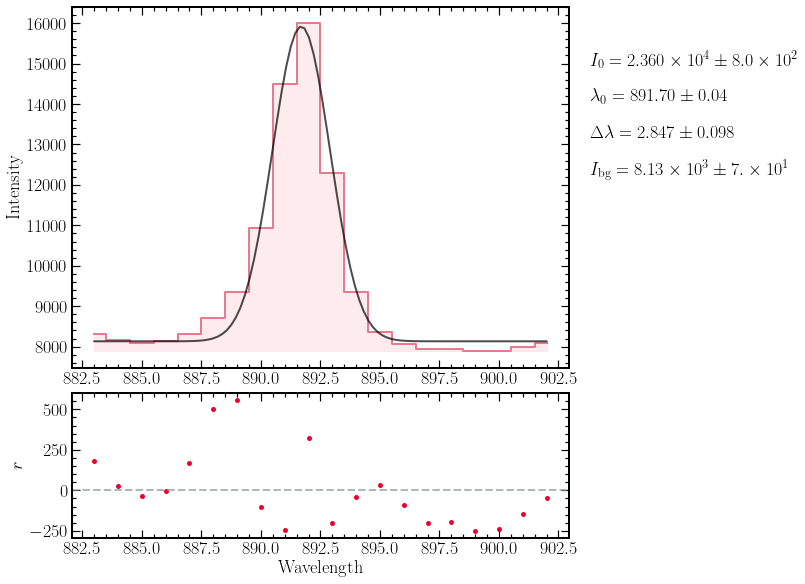

In [176]:
HeI_D3_slice_57_red = slice(883 - red_frame.header["XWS"],903 - red_frame.header["XWS"])
HeI_D3_model_57_red = SpectrumFitSingle(data=np.average(red_image[592 - red_frame.header["YWS"]:596 - red_frame.header["YWS"],
                    HeI_D3_slice_57_red],axis=0), 
                    wvl=red_xpixel_array[HeI_D3_slice_57_red],line_number=1,line_wvl_init=[891.45],
                    int_max_init=50000,fwhm_init=[1],same_width=False)
HeI_D3_model_57_red.run_lse(absolute_sigma=False)
ax = HeI_D3_model_57_red.plot(plot_fit=True)
HeI_D3_pixel_diff_57_red = HeI_D3_model_57_red.line_wvl_fit[0] - 890.45
HeI_D3_pixel_diff_57_red_err = np.sqrt(HeI_D3_model_57_red.line_wvl_err[0]**2 + 0.04**2)

HeI_D3_wvl_diff_57_red = np.interp(HeI_D3_model_57_red.line_wvl_fit[0], red_xpixel_array, red_wavelength/57./10.) - HeI_D3_wvl
HeI_D3_wvl_diff_57_red_err = np.abs(np.interp(HeI_D3_model_57_red.line_wvl_fit[0] + HeI_D3_model_57_red.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/57./10.) - HeI_D3_wvl - HeI_D3_wvl_diff_57_red)

HeI_D3_vlos_diff_57_red = HeI_D3_wvl_diff_57_red/HeI_D3_wvl*3e5
HeI_D3_vlos_diff_57_red_err = HeI_D3_wvl_diff_57_red_err/HeI_D3_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(HeI_D3_pixel_diff_57_red, HeI_D3_pixel_diff_57_red_err,
                                                HeI_D3_wvl_diff_57_red,HeI_D3_wvl_diff_57_red_err, HeI_D3_vlos_diff_57_red,HeI_D3_vlos_diff_57_red_err))

Pixel diff: 1.34 +/- 0.08 
 Wavelength diff: 0.038 +/- 0.001 nm 19.6 +/- 0.7 km/s


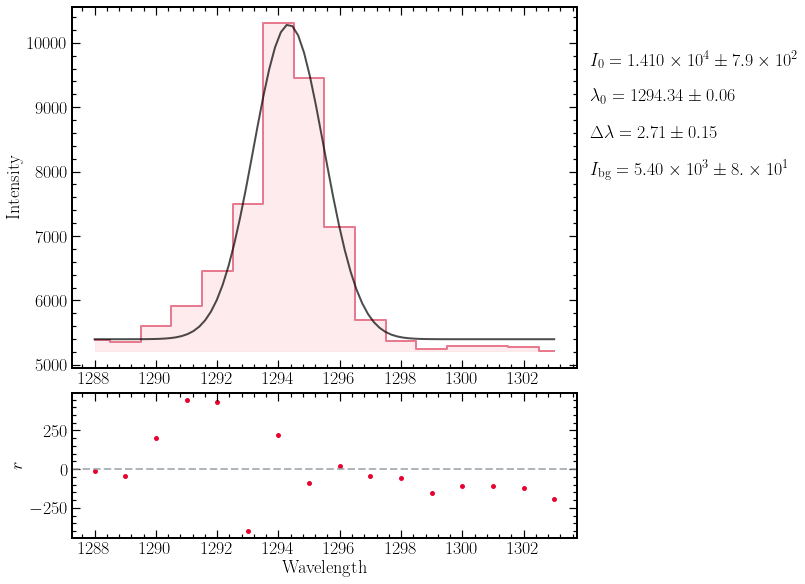

In [177]:
HeI_D3_slice_58_red = slice(1288 - red_frame.header["XWS"],1304 - red_frame.header["XWS"])
HeI_D3_model_58_red = SpectrumFitSingle(data=np.average(red_image[592 - red_frame.header["YWS"]:596 - red_frame.header["YWS"],
                    HeI_D3_slice_58_red],axis=0), 
                    wvl=red_xpixel_array[HeI_D3_slice_58_red],line_number=1,line_wvl_init=[1294.00],
                    int_max_init=50000,fwhm_init=[1],same_width=False)
HeI_D3_model_58_red.run_lse(absolute_sigma=False)
ax = HeI_D3_model_58_red.plot(plot_fit=True)
HeI_D3_pixel_diff_58_red = HeI_D3_model_58_red.line_wvl_fit[0] - 1293.00
HeI_D3_pixel_diff_58_red_err = np.sqrt(HeI_D3_model_58_red.line_wvl_err[0]**2 + 0.05**2)

HeI_D3_wvl_diff_58_red = np.interp(HeI_D3_model_58_red.line_wvl_fit[0], red_xpixel_array, red_wavelength/58./10.) - HeI_D3_wvl
HeI_D3_wvl_diff_58_red_err = np.abs(np.interp(HeI_D3_model_58_red.line_wvl_fit[0] + HeI_D3_model_58_red.line_wvl_err[0], 
                    red_xpixel_array, red_wavelength/58./10.) - HeI_D3_wvl - HeI_D3_wvl_diff_58_red)

HeI_D3_vlos_diff_58_red = HeI_D3_wvl_diff_58_red/HeI_D3_wvl*3e5
HeI_D3_vlos_diff_58_red_err = HeI_D3_wvl_diff_58_red_err/HeI_D3_wvl*3e5

print("Pixel diff: {:.2f} +/- {:.2f} \n Wavelength diff: {:.3f} +/- {:.3f} nm {:.1f} +/- {:.1f} km/s".format(HeI_D3_pixel_diff_58_red, HeI_D3_pixel_diff_58_red_err,
                                                HeI_D3_wvl_diff_58_red,HeI_D3_wvl_diff_58_red_err, HeI_D3_vlos_diff_58_red,HeI_D3_vlos_diff_58_red_err))

In [179]:
Halpha_centorid_pixels = np.array([Halpha_model_49.line_wvl_fit[0],Halpha_model_50.line_wvl_fit[0],
                                Halpha_model_51.line_wvl_fit[0],Halpha_model_52.line_wvl_fit[0]])
HeI_D3_centorid_pixels_red = np.array([HeI_D3_model_55_red.line_wvl_fit[0],HeI_D3_model_56_red.line_wvl_fit[0],
                                HeI_D3_model_57_red.line_wvl_fit[0],HeI_D3_model_58_red.line_wvl_fit[0]])    

Halpha_centorid_pixels_err = np.array([Halpha_model_49.line_wvl_err[0],Halpha_model_50.line_wvl_err[0],
                                Halpha_model_51.line_wvl_err[0],Halpha_model_52.line_wvl_err[0]])
HeI_D3_centorid_pixels_red_err = np.array([HeI_D3_model_55_red.line_wvl_err[0],HeI_D3_model_56_red.line_wvl_err[0],
                                HeI_D3_model_57_red.line_wvl_err[0],HeI_D3_model_58_red.line_wvl_err[0]])    

Halpha_pixel_diffs = np.array([Halpha_pixel_diff_49,Halpha_pixel_diff_50,Halpha_pixel_diff_51,Halpha_pixel_diff_52])            
HeI_D3_pixel_diffs_red = np.array([HeI_D3_pixel_diff_55_red,HeI_D3_pixel_diff_56_red,HeI_D3_pixel_diff_57_red,HeI_D3_pixel_diff_58_red])

Halpha_pixel_diffs_err = np.array([Halpha_pixel_diff_49_err,Halpha_pixel_diff_50_err,Halpha_pixel_diff_51_err,Halpha_pixel_diff_52_err])            
HeI_D3_pixel_diffs_red_err = np.array([HeI_D3_pixel_diff_55_red_err,HeI_D3_pixel_diff_56_red_err,HeI_D3_pixel_diff_57_red_err,HeI_D3_pixel_diff_58_red_err])

Halpha_wvl_diffs = np.array([Halpha_wvl_diff_49,Halpha_wvl_diff_50,Halpha_wvl_diff_51,Halpha_wvl_diff_52])    
HeI_D3_wvl_diffs_red = np.array([HeI_D3_wvl_diff_55_red,HeI_D3_wvl_diff_56_red,HeI_D3_wvl_diff_57_red,HeI_D3_wvl_diff_58_red])

Halpha_wvl_diffs_err = np.array([Halpha_wvl_diff_49_err,Halpha_wvl_diff_50_err,Halpha_wvl_diff_51_err,Halpha_wvl_diff_52_err])    
HeI_D3_wvl_diffs_red_err = np.array([HeI_D3_wvl_diff_55_red_err,HeI_D3_wvl_diff_56_red_err,HeI_D3_wvl_diff_57_red_err,HeI_D3_wvl_diff_58_red_err])

Halpha_vlos_diffs = np.array([Halpha_vlos_diff_49,Halpha_vlos_diff_50,Halpha_vlos_diff_51,Halpha_vlos_diff_52])    
HeI_D3_vlos_diffs_red = np.array([HeI_D3_vlos_diff_55_red,HeI_D3_vlos_diff_56_red,HeI_D3_vlos_diff_57_red,HeI_D3_vlos_diff_58_red])

Halpha_vlos_diffs_err = np.array([Halpha_vlos_diff_49_err,Halpha_vlos_diff_50_err,Halpha_vlos_diff_51_err,Halpha_vlos_diff_52_err])    
HeI_D3_vlos_diffs_red_err = np.array([HeI_D3_vlos_diff_55_red_err,HeI_D3_vlos_diff_56_red_err,HeI_D3_vlos_diff_57_red_err,HeI_D3_vlos_diff_58_red_err])

Averaged pixel shift: 1.173


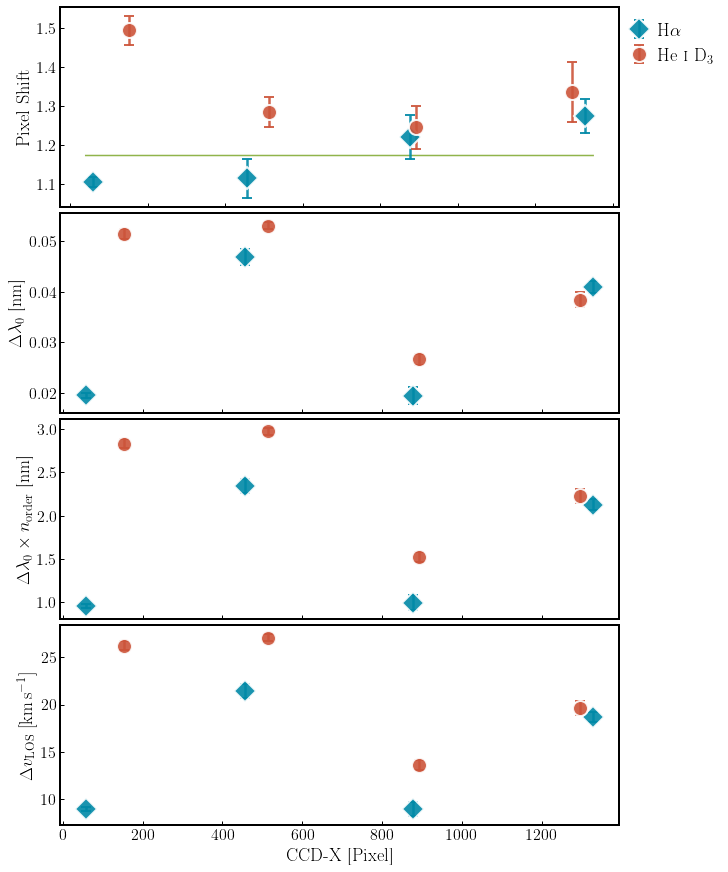

In [193]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(10,12),constrained_layout=True)

ax1.errorbar(Halpha_centorid_pixels, Halpha_pixel_diffs,Halpha_pixel_diffs_err,color="#0089A7",ls="none",marker="D",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"H$\alpha$")

ax1.errorbar(HeI_D3_centorid_pixels_red, HeI_D3_pixel_diffs_red,HeI_D3_pixel_diffs_red_err,color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"He \textsc{i} $\mathrm{D_3}$")

ax1.legend(bbox_to_anchor = (1.2,1),loc="upper right",fontsize=18,frameon=False,handletextpad=0.1)

red_abs_wvl_corr_params = np.polyfit(np.concatenate((Halpha_centorid_pixels, HeI_D3_centorid_pixels_red)),
                                    np.concatenate((Halpha_pixel_diffs, HeI_D3_pixel_diffs_red)),
                                    w = 1./np.concatenate((Halpha_pixel_diffs_err, HeI_D3_pixel_diffs_red_err)),
                                    deg = 0)

red_abs_wvl_corr_poly = np.poly1d(red_abs_wvl_corr_params)

ax1.plot(np.linspace(red_frame.header["XWS"],red_frame.header["XWS"]+red_frame.header["NAXIS1"],red_frame.header["NAXIS1"]), 
        red_abs_wvl_corr_poly(np.linspace(red_frame.header["XWS"],red_frame.header["XWS"]+red_frame.header["NAXIS1"],red_frame.header["NAXIS1"])),
        color="#90B44B",zorder=0)

ax2.errorbar(Halpha_centorid_pixels, Halpha_wvl_diffs,Halpha_wvl_diffs_err,color="#0089A7",ls="none",marker="D",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"H$\alpha$")

ax2.errorbar(HeI_D3_centorid_pixels_red, HeI_D3_wvl_diffs_red,HeI_D3_wvl_diffs_red_err,color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"He \textsc{i} $\mathrm{D_3}$")

ax3.errorbar(Halpha_centorid_pixels, Halpha_wvl_diffs*np.array([49,50,51,52]),
            Halpha_wvl_diffs_err*np.array([49,50,51,52]),color="#0089A7",ls="none",marker="D",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"H$\alpha$")

ax3.errorbar(HeI_D3_centorid_pixels_red, HeI_D3_wvl_diffs_red*np.array([55,56,57,58]),
            HeI_D3_wvl_diffs_red_err*np.array([55,56,57,58]),color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"He \textsc{i} $\mathrm{D_3}$")

ax4.errorbar(Halpha_centorid_pixels, Halpha_vlos_diffs,Halpha_vlos_diffs_err,color="#0089A7",ls="none",marker="D",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"H$\alpha$")

ax4.errorbar(HeI_D3_centorid_pixels_red, HeI_D3_vlos_diffs_red,HeI_D3_vlos_diffs_red_err,color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5,label=r"He \textsc{i} $\mathrm{D_3}$")


ax1.set_ylabel(r"Pixel Shift",fontsize=18)
ax2.set_ylabel(r"$\Delta\lambda_{0}$ [nm]",fontsize=18)
ax3.set_ylabel(r"$\Delta\lambda_{0}\times n_{\rm order}$ [nm]",fontsize=18)
ax4.set_ylabel(r"$\Delta v_{\rm LOS}\ [\mathrm{km\,s^{-1}}]$",fontsize=18)
ax4.set_xlabel(r"CCD-X [Pixel]",fontsize=18)
for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4):
    ax_.tick_params(labelsize=16,direction="in")

print("Averaged pixel shift: {:.3f}".format(red_abs_wvl_corr_poly(500)))
    